In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import us
import plotly.express as px
import mplcursors
import matplotlib as mpl
from pyspark.sql import SparkSession
import findspark
from pyspark.sql import functions as F
import seaborn as sns
from pyspark.sql.functions import mean



In [4]:

findspark.init()
# Start Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("sparkFunctions").getOrCreate()
from pyspark import SparkFiles
csv_file_paths = [
    "Resources/CurrentPopulationSurvey_1981.csv",
    "Resources/CurrentPopulationSurvey_1990.csv",
    "Resources/CurrentPopulationSurvey_1999.csv",
    "Resources/CurrentPopulationSurvey_2007.csv",
    "Resources/CurrentPopulationSurvey_2009.csv",
    "Resources/CurrentPopulationSurvey_2011.csv",
    "Resources/CurrentPopulationSurvey_2013.csv"
]
# Read each CSV file into a DataFrame and store them in a list
dfs = [spark.read.csv(path, sep=",", header=True, ignoreLeadingWhiteSpace=True) for path in csv_file_paths]

# Combine all DataFrames into a single DataFrame using union
combined_df = dfs[0]  # Start with the first DataFrame
for df in dfs[1:]:  # Iterate through the rest of the DataFrames
    combined_df = combined_df.union(df)

# Show the combined DataFrame
combined_df.show()


+----+--------------------+---------+---+-----+----+--------+--------------------+----------+------+---+---+--------+--------+-------+
|year|          state name| region_1|age|sex_1|race|  race_1|      martial status|union type|educ99|occ|ind|wkswork1|uhrswork|incwage|
+----+--------------------+---------+---+-----+----+--------+--------------------+----------+------+---+---+--------+--------+-------+
|1981|            Virginia|    South| 38| male|   4|   Other|Married, spouse p...|      NULL|  NULL|245|798|      52|      40|17000.0|
|1981|             Vermont|Northeast| 58| male|   1|   White|Married, spouse p...|      NULL|  NULL|470|339|      52|      48|19000.0|
|1981|                Utah|     West| 35| male|   1|   White|Married, spouse p...|      NULL|  NULL|715|417|      52|      43|21000.0|
|1981|            Illinois|  Midwest| 33| male|   1|   White|            Divorced|      NULL|  NULL|485|857|      52|      60|19740.0|
|1981|District of Columbia|    South| 45| male|   2|   

In [5]:
combined_df.printSchema()


root
 |-- year: string (nullable = true)
 |-- state name: string (nullable = true)
 |-- region_1: string (nullable = true)
 |-- age: string (nullable = true)
 |-- sex_1: string (nullable = true)
 |-- race: string (nullable = true)
 |-- race_1: string (nullable = true)
 |-- martial status: string (nullable = true)
 |-- union type: string (nullable = true)
 |-- educ99: string (nullable = true)
 |-- occ: string (nullable = true)
 |-- ind: string (nullable = true)
 |-- wkswork1: string (nullable = true)
 |-- uhrswork: string (nullable = true)
 |-- incwage: string (nullable = true)



In [6]:
# Group by 'industry' and 'sex_1', then calculate the mean income
grouped_data = combined_df.groupBy(['ind', 'sex_1']).agg(F.mean('incwage').alias('average_income'))

# Pivot to create a wide-format DataFrame
industries = grouped_data.groupBy('ind').pivot('sex_1').agg(F.first('average_income'))

# Show the final output
industries.show()



+----+------------------+------------------+
| ind|            female|              male|
+----+------------------+------------------+
| 467|          12962.54|23124.873646209388|
| 829|           8890.48|         38091.875|
| 691|          20293.75|35968.230769230766|
|1090|35828.368055555555| 47134.19626168224|
| 800|24745.752808988764| 42802.96923076923|
| 451|54423.444444444445|           50588.0|
| 870|17812.933333333334|24772.436619718308|
|1280| 33015.17931034483| 49668.95283018868|
|1870| 45412.27272727273| 63169.59581881533|
| 447| 13097.41935483871| 20136.73846153846|
| 591| 15051.69366197183| 27778.49393939394|
|6380| 35951.43265306122| 53481.00378310215|
| 718|10491.079166666666| 17397.55744680851|
| 307| 7942.333333333333| 16842.91304347826|
| 747| 8633.583333333334|11055.134328358208|
| 740|26041.570652173912| 33859.08888888889|
| 581|          12960.22| 26189.98305084746|
|1880|30850.708333333332| 49466.08928571428|
|4690|         26966.576| 38917.16312056738|
|8680|1943

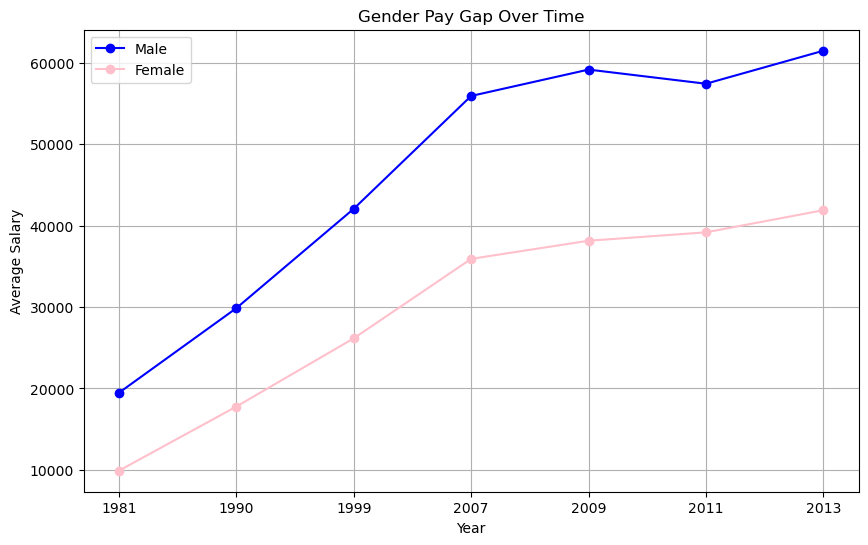

In [7]:
male_data = combined_df[combined_df['sex_1'] == 'male']
female_data = combined_df[combined_df['sex_1'] == 'female']

# First, calculate average salary for males and females grouped by year
avg_salary_male_year = male_data.groupBy('year').agg({'incwage': 'mean'}).withColumnRenamed('avg(incwage)', 'avg_salary')
avg_salary_female_year = female_data.groupBy('year').agg({'incwage': 'mean'}).withColumnRenamed('avg(incwage)', 'avg_salary')

# Convert the results to Pandas DataFrames for plotting
avg_salary_male_year_pd = avg_salary_male_year.toPandas()
avg_salary_female_year_pd = avg_salary_female_year.toPandas()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(avg_salary_male_year_pd['year'], avg_salary_male_year_pd['avg_salary'], label='Male', color='blue', marker='o')
plt.plot(avg_salary_female_year_pd['year'], avg_salary_female_year_pd['avg_salary'], label='Female', color='pink', marker='o')

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Average Salary')
plt.title('Gender Pay Gap Over Time')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


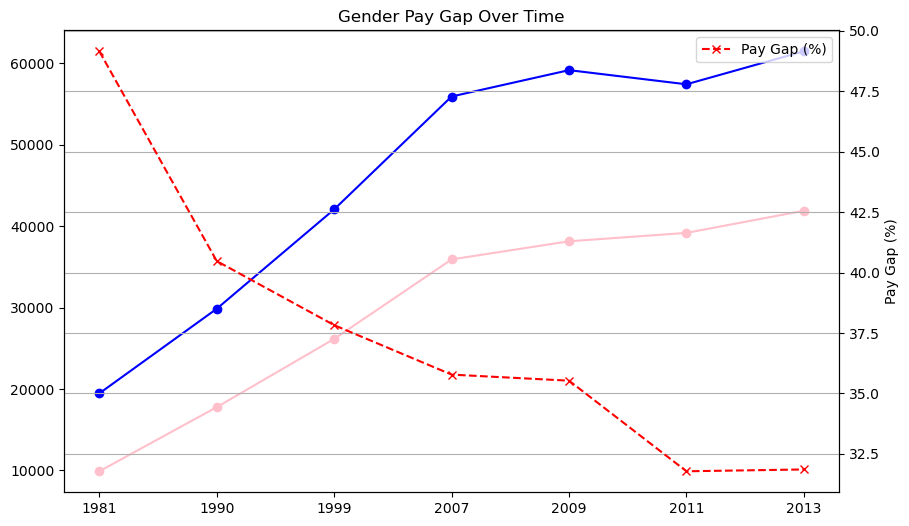

In [8]:
# Merge the male and female salary dataframes on the 'year' column
merged_df = avg_salary_male_year_pd.merge(avg_salary_female_year_pd, on='year', suffixes=('_male', '_female'))

# Calculate the percentage pay gap
merged_df['pay_gap_percentage'] = ((merged_df['avg_salary_male'] - merged_df['avg_salary_female']) / merged_df['avg_salary_male']) * 100

# Plotting
plt.figure(figsize=(10, 6))

# Plot the average salary for males and females
plt.plot(merged_df['year'], merged_df['avg_salary_male'], label='Male Avg Salary', color='blue', marker='o')
plt.plot(merged_df['year'], merged_df['avg_salary_female'], label='Female Avg Salary', color='pink', marker='o')

# Add secondary y-axis for the pay gap percentage
ax2 = plt.gca().twinx()  # Create a secondary axis
ax2.plot(merged_df['year'], merged_df['pay_gap_percentage'], label='Pay Gap (%)', color='red', marker='x', linestyle='--')

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Average Salary')
ax2.set_ylabel('Pay Gap (%)')
plt.title('Gender Pay Gap Over Time')

# Add legends for both plots
plt.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot with grid
plt.grid(True)
plt.show()


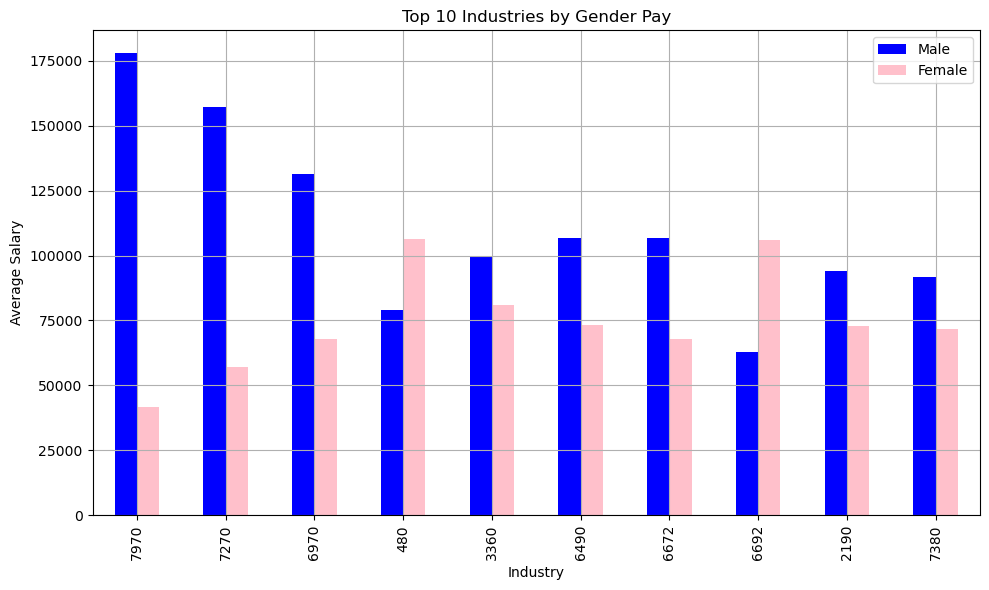

In [9]:
industries = combined_df.groupBy(['ind', 'sex_1']).agg(F.mean('incwage').alias('avg_salary'))

# Pivot the DataFrame to get male and female salaries in separate columns
industries_pivoted = industries.groupBy('ind').pivot('sex_1').agg(F.first('avg_salary')).na.fill(0)

# Step 3: Calculate total salary (sum of male and female average salaries) and get top 10 industries
industries_pivoted = industries_pivoted.withColumn('total_salary', industries_pivoted['male'] + industries_pivoted['female'])
top_10_industries = industries_pivoted.orderBy('total_salary', ascending=False).limit(10)

# Convert to Pandas DataFrame for plotting
top_10_industries_pd = top_10_industries.toPandas()

# Step 4: Plot the top 10 industries with a stacked bar chart
top_10_industries_pd.set_index('ind')[['male', 'female']].plot(kind='bar', stacked=False, figsize=(10, 6), color=['blue', 'pink'])

# Add labels and title
plt.title('Top 10 Industries by Gender Pay')
plt.xlabel('Industry')
plt.ylabel('Average Salary')
plt.legend(['Male', 'Female'], loc='upper right')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

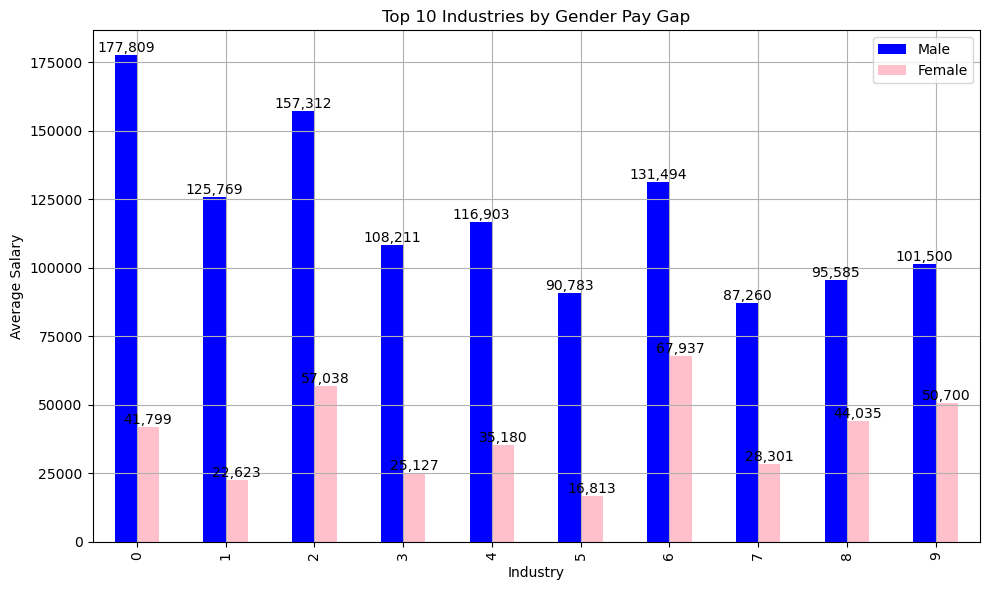

In [10]:
# Group data by industry and gender, and calculate the mean income wage
industries = (combined_df
              .groupBy('ind', 'sex_1')
              .agg(F.mean('incwage').alias('avg_income'))
              .groupBy('ind')
              .pivot('sex_1')
              .agg(F.first('avg_income')))

#Calculate the gender pay gap (difference between male and female average salary)
industries = industries.withColumn('pay_gap', industries['male'] - industries['female'])

#Sort the industries by pay gap and select the top 10
top_10_industries = industries.orderBy('pay_gap', ascending=False).limit(10)

#Collect the data for plotting
top_10_industries_pd = top_10_industries.toPandas()

#Plot the top 10 industries with a bar chart
ax = top_10_industries_pd[['male', 'female']].plot(kind='bar', stacked=False, figsize=(10, 6), color=['blue', 'pink'])

# Adding data labels
for p in ax.patches:
    ax.annotate(f'{p.get_height():,.0f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=10, color='black', rotation=0)

# Add labels and title
plt.title('Top 10 Industries by Gender Pay Gap')
plt.xlabel('Industry')
plt.ylabel('Average Salary')
plt.legend(['Male', 'Female'], loc='upper right')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

In [11]:
#Group by industry and gender, and calculate the average salary
grouped_data = (combined_df
                .groupBy('ind', 'sex_1')
                .agg(F.mean('incwage').alias('avg_incwage')))

# Pivot the DataFrame to get a wide format with genders as columns
grouped_data = grouped_data.groupBy('ind').pivot('sex_1', ['male', 'female']).agg(F.first('avg_incwage'))

#Calculate the pay gap (male salary - female salary)
grouped_data = grouped_data.withColumn('pay_gap', grouped_data['male'] - grouped_data['female'])

#Sort by the largest pay gap and select the top 10
top_10_industries = grouped_data.sort('pay_gap', ascending=False).limit(10)

#Convert to Pandas DataFrame for plotting if needed
top_10_industries_pd = top_10_industries.toPandas()

# Now you can plot using Plotly as before
import plotly.graph_objects as go

fig = go.Figure()

# Add male salaries
fig.add_trace(go.Bar(
    x=top_10_industries_pd['ind'], 
    y=top_10_industries_pd['male'], 
    name='Male Salary',
    marker_color='blue',
    hovertemplate='Industry: %{x}<br>Male Salary: %{y}<extra></extra>'
))

# Add female salaries
fig.add_trace(go.Bar(
    x=top_10_industries_pd['ind'], 
    y=top_10_industries_pd['female'], 
    name='Female Salary',
    marker_color='pink',
    hovertemplate='Industry: %{x}<br>Female Salary: %{y}<extra></extra>'
))

# Customize layout
fig.update_layout(
    title='Top 10 Industries by Gender Pay Gap',
    xaxis_title='Industry',
    yaxis_title='Average Salary',
    barmode='group',
    hovermode='x unified'
)

# Show plot
fig.show()

24/10/07 21:25:11 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


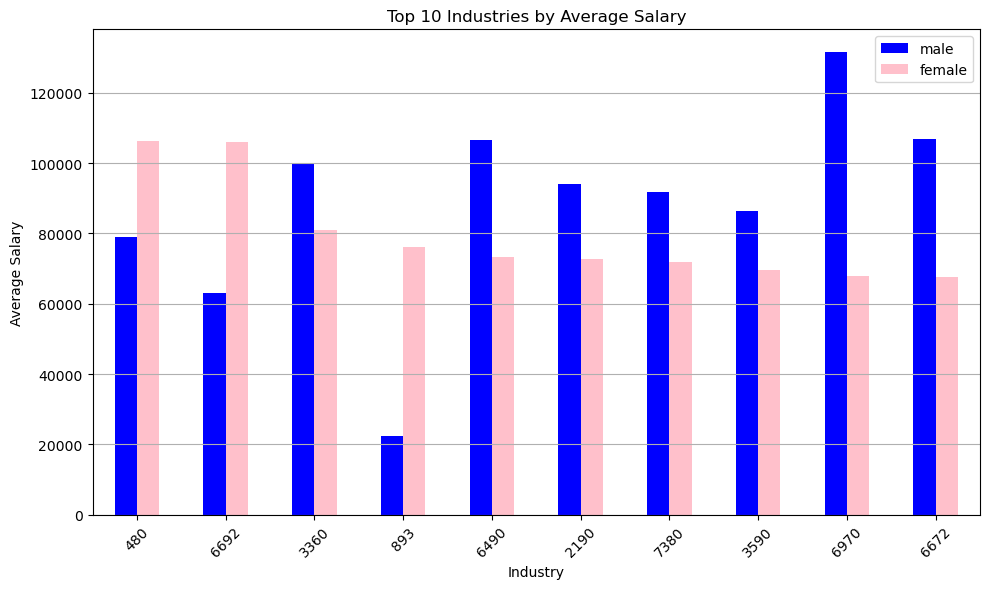

             female           male  Income Difference
ind                                                  
480   106250.000000   79010.086957       27239.913043
6692  105894.400000   62978.260870       42916.139130
3360   80894.356688   99728.116402      -18833.759714
893    76135.181818   22340.800000       53794.381818
6490   73356.338710  106667.306306      -33310.967597
2190   72755.410188   94057.342380      -21301.932192
7380   71781.144197   91735.759137      -19954.614940
3590   69574.243590   86446.058052      -16871.814463
6970   67937.390402  131493.544534      -63556.154132
6672   67730.160000  106880.795918      -39150.635918


In [12]:
# Create Spark session
spark = SparkSession.builder.appName("Gender Pay Gap").getOrCreate()

# Load the DataFrame (replace with your actual DataFrame path)
# combined_df = spark.read.csv("your_file.csv", header=True, inferSchema=True)

#Group by industry and gender, and calculate the average salary
industry_income = (combined_df
                   .groupBy('ind', 'sex_1')
                   .agg(mean('incwage').alias('mean_income')))

# Pivot the DataFrame to get separate columns for Male and Female
industry_income_pivot = industry_income.groupBy('ind').pivot('sex_1').agg(mean('mean_income'))

#Handle missing values (if necessary)
industry_income_pivot = industry_income_pivot.fillna(0)

#Convert to Pandas DataFrame for plotting
industry_income_pd = industry_income_pivot.toPandas()

#Calculate average salary for male and female and add a column for the difference
industry_income_pd['Income Difference'] = industry_income_pd['female'] - industry_income_pd['male']

#Sort the DataFrame by average female salary (or male salary) and get the top 10
top_10_industries = industry_income_pd.sort_values(by='female', ascending=False).head(10)

#Plotting the top 10 industries
top_10_industries.set_index('ind', inplace=True)  # Set 'ind' as index for better plotting
top_10_industries[['male', 'female']].plot(kind='bar', figsize=(10, 6), color=['blue', 'pink'])

# Add labels and title
plt.title('Top 10 Industries by Average Salary')
plt.xlabel('Industry')
plt.ylabel('Average Salary')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Show the plot
plt.tight_layout()
plt.show()

# Optional: Display the top 10 DataFrame
print(top_10_industries)

In [13]:
combined_df.printSchema()

root
 |-- year: string (nullable = true)
 |-- state name: string (nullable = true)
 |-- region_1: string (nullable = true)
 |-- age: string (nullable = true)
 |-- sex_1: string (nullable = true)
 |-- race: string (nullable = true)
 |-- race_1: string (nullable = true)
 |-- martial status: string (nullable = true)
 |-- union type: string (nullable = true)
 |-- educ99: string (nullable = true)
 |-- occ: string (nullable = true)
 |-- ind: string (nullable = true)
 |-- wkswork1: string (nullable = true)
 |-- uhrswork: string (nullable = true)
 |-- incwage: string (nullable = true)



In [14]:
grouped_data.head()

Row(ind='467', male=23124.873646209388, female=12962.54, pay_gap=10162.333646209387)

In [15]:
combined_df.printSchema()

root
 |-- year: string (nullable = true)
 |-- state name: string (nullable = true)
 |-- region_1: string (nullable = true)
 |-- age: string (nullable = true)
 |-- sex_1: string (nullable = true)
 |-- race: string (nullable = true)
 |-- race_1: string (nullable = true)
 |-- martial status: string (nullable = true)
 |-- union type: string (nullable = true)
 |-- educ99: string (nullable = true)
 |-- occ: string (nullable = true)
 |-- ind: string (nullable = true)
 |-- wkswork1: string (nullable = true)
 |-- uhrswork: string (nullable = true)
 |-- incwage: string (nullable = true)



<class 'pyspark.sql.dataframe.DataFrame'>
root
 |-- year: string (nullable = true)
 |-- state name: string (nullable = true)
 |-- region_1: string (nullable = true)
 |-- age: string (nullable = true)
 |-- sex_1: string (nullable = true)
 |-- race: string (nullable = true)
 |-- race_1: string (nullable = true)
 |-- martial status: string (nullable = true)
 |-- union type: string (nullable = true)
 |-- educ99: string (nullable = true)
 |-- occ: string (nullable = true)
 |-- ind: string (nullable = true)
 |-- wkswork1: string (nullable = true)
 |-- uhrswork: string (nullable = true)
 |-- incwage: string (nullable = true)

+----+--------------------+---------+---+-----+----+------+--------------------+----------+------+---+---+--------+--------+-------+
|year|          state name| region_1|age|sex_1|race|race_1|      martial status|union type|educ99|occ|ind|wkswork1|uhrswork|incwage|
+----+--------------------+---------+---+-----+----+------+--------------------+----------+------+---+---+-

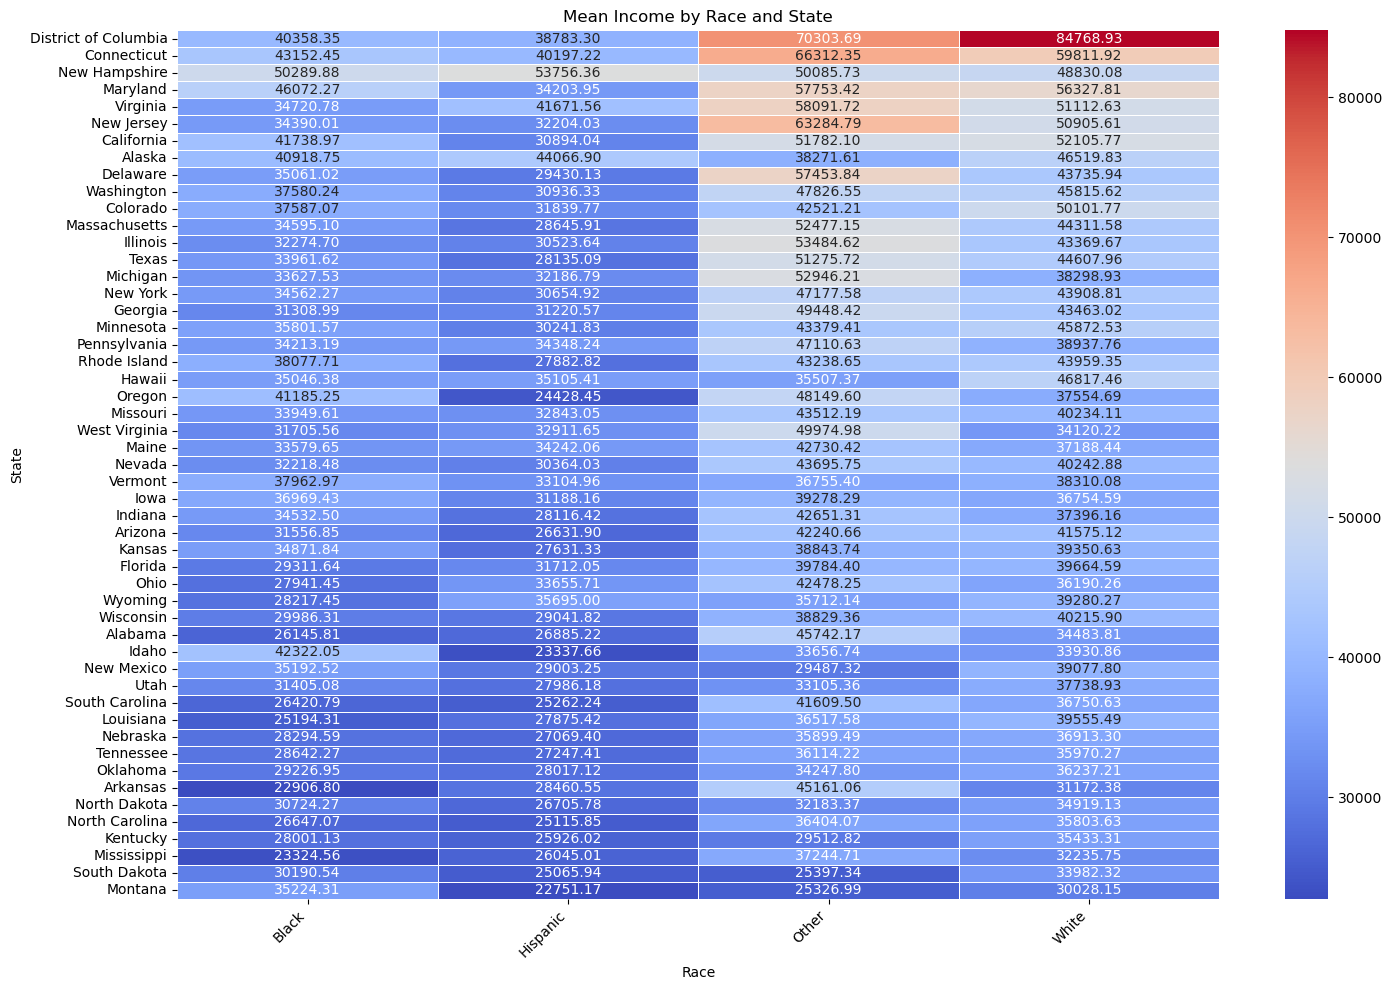

In [16]:
print(type(combined_df))

# If it's a Pandas DataFrame, convert it to a PySpark DataFrame
if isinstance(combined_df, pd.DataFrame):
    combined_df = spark.createDataFrame(combined_df)

# Show the schema of grouped_data to check for available columns
combined_df.printSchema()
combined_df.show(5)

# Group the data to calculate mean income by state and race
mean_data = combined_df.groupBy('state name', 'race_1').agg(F.mean('incwage').alias('mean')).toPandas()

# Pivot the data to get mean income by race and state
heatmap_data = mean_data.pivot(index='state name', columns='race_1', values='mean')

# Calculate the overall mean income per state (mean across all races)
heatmap_data['Overall_Mean'] = heatmap_data.mean(axis=1)

# Sort the states by the overall mean income in descending order
heatmap_data_sorted = heatmap_data.sort_values(by='Overall_Mean', ascending=False).drop(columns='Overall_Mean')

# Create a heatmap with annotations
plt.figure(figsize=(15, 10))
sns.heatmap(heatmap_data_sorted, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5, annot_kws={"size": 10})
plt.title('Mean Income by Race and State')
plt.ylabel('State')
plt.xlabel('Race')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [17]:
# Group the data by industry ('ind') and sex ('sex_1'), then calculate mean income ('incwage')
industry_income = combined_df.groupBy('ind', 'sex_1').agg(F.mean('incwage').alias('mean_incwage'))

# Pivot the DataFrame to reshape it
industry_income_pivot = industry_income.groupBy('ind').pivot('sex_1', ['male', 'female']).agg(F.first('mean_incwage'))

# Rename columns for clarity
industry_income_pivot = industry_income_pivot.withColumnRenamed('Male', 'Male').withColumnRenamed('Female', 'Female')

# Fill NaNs with median income for each group
# Note: PySpark does not have a direct method for filling NaNs like Pandas, so you can use the following workaround:
median_male = industry_income_pivot.select(F.expr('percentile_approx(male, 0.5)').alias('median')).collect()[0]['median']
median_female = industry_income_pivot.select(F.expr('percentile_approx(female, 0.5)').alias('median')).collect()[0]['median']

industry_income_pivot = industry_income_pivot.fillna({'Male': median_male, 'Female': median_female})

# Calculate Income Difference
industry_income_pivot = industry_income_pivot.withColumn('Income Difference', industry_income_pivot['Female'] - industry_income_pivot['Male'])
industry_income_pivot = industry_income_pivot.withColumn('abs_diff', F.abs(industry_income_pivot['Income Difference']))

# Check for remaining NaN values
if industry_income_pivot.filter(F.isnan('abs_diff') | F.isnan('Income Difference')).count() > 0:
    print("NaN values found in 'abs_diff' or 'Income Difference'. Filling with 0.")
    industry_income_pivot = industry_income_pivot.fillna({'Income Difference': 0})

# Using Plotly as before
import plotly.express as px

# Create a scatter plot with Plotly
fig = px.scatter(industry_income_pivot.toPandas(), x='Male', y='Female', 
                 size='abs_diff', color='Income Difference', 
                 hover_data=['ind', 'Male', 'Female', 'Income Difference'],
                 title='Gender Pay Gap Across Industries',
                 labels={'Male': 'Average Male Income', 'Female': 'Average Female Income'},
                 color_continuous_scale='Viridis',
                 size_max=100)

# Add line for equal pay
fig.add_shape(type='line', x0=0, y0=0, x1=industry_income_pivot.select(F.max('Male')).first()[0], 
              y1=industry_income_pivot.select(F.max('Female')).first()[0], 
              line=dict(color='gray', dash='dash'))

# Show the interactive plot
fig.show()